In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from ode_model import *
from utils import *
import ode_model
import utils
import importlib
import run_model
from run_model import *
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import json
import pickle
from pygrinder import mcar

In [2]:
importlib.reload(run_model)
importlib.reload(ode_model)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\camipm\\Documents\\aswain\\CESTODE_Impute\\utils.py'>

In [3]:
np.random.seed(42)

## Load and prepare the data

In [4]:
data = np.load(r"C:\Users\camipm\Documents\aswain\CESTODE_Imputation\ZSpecData_nopkl.npz", allow_pickle = True)

In [5]:
zspec = data['trainData']
nonzeroInds = data['train_nonZeroInds']

zspec = zspec[nonzeroInds]
nonNanInds = data['train_nonNanInds']
zpsec = zspec[nonNanInds]
print(zspec.shape)
print(np.max(zspec))

(663397, 56, 3)
8492.899


In [6]:
B1 = np.array([28,50,70])
B1 = np.tile(B1, [zspec.shape[0], 1])
print(B1.shape)

(663397, 3)


In [7]:
zspec = np.swapaxes(zspec,1,-1)
zspec = zspec.reshape(-1,56)
print(zspec.shape)

B1 = B1.reshape(-1,1)
print(B1.shape)

(1990191, 56)
(1990191, 1)


In [8]:
satDur = 3
satDur = np.repeat(3, zspec.shape[0])
satDur = satDur.reshape(-1,1)
print(satDur.shape)

(1990191, 1)


In [9]:
offsets = np.loadtxt('CESTppmlist_7T.txt')
print(offsets)
print(len(offsets))

[-300.  -100.   -50.   -20.   -12.    -9.    -7.2   -6.2   -5.5   -4.7
   -4.    -3.3   -2.7   -2.    -1.7   -1.5   -1.1   -0.9   -0.6   -0.4
    0.     0.4    0.6    0.9    1.1    1.2    1.4    1.5    1.7    1.8
    2.     2.1    2.3    2.4    2.6    2.7    2.9    3.     3.2    3.3
    3.5    3.6    3.8    3.9    4.1    4.2    4.4    4.7    5.2    6.2
    8.    12.    20.    50.   100.   300. ]
56


In [10]:
trainIndsSelect = np.random.randint(low = 0, high = zspec.shape[0], size = int(1e6))
zspec = zspec[trainIndsSelect,:]
B1 = B1[trainIndsSelect,:]
satDur = satDur[trainIndsSelect,:]

In [11]:
# normalize B1
B1 = (B1 - np.min(B1)) / (np.max(B1) - np.min(B1))
print(B1)

[[1.        ]
 [0.52380952]
 [0.52380952]
 ...
 [0.52380952]
 [1.        ]
 [0.52380952]]


### Create training and validation sets

In [12]:
# split data in training and validation sets
trainData, valData, trainInds, valInds = train_test_split(zspec,np.arange(len(zspec)),test_size = 0.3, random_state = 42)

train_B1 = B1[trainInds,:]
val_B1 = B1[valInds,:]

train_sat = satDur[trainInds,:]
val_sat = satDur[valInds,:]

In [13]:
X_train_ori = trainData
X_val_ori = valData

X_train = mcar(X_train_ori, 0.3)
X_val = mcar(X_val_ori, 0.2)

X_train_mask = ~np.isnan(X_train) + 0
X_val_mask = ~np.isnan(X_val) + 0

In [14]:
print(X_train[0,:])
print(X_train_mask[0,:])

[       nan 0.98891604 0.9305286  0.7677228  0.6755667  0.61894053
 0.5813596  0.5517044         nan        nan 0.47132957 0.4499301
        nan 0.43859464        nan 0.4211511  0.3830218         nan
        nan        nan 0.06205162        nan 0.22002673        nan
        nan 0.3791248         nan 0.42279002 0.43938956 0.44330698
        nan        nan 0.48165098 0.48793507 0.50022674 0.50547206
 0.5182979  0.5243451         nan 0.5322554         nan 0.54343516
 0.55127454        nan        nan        nan 0.57951796        nan
        nan 0.643197   0.6761007  0.72678006 0.8024126         nan
 0.979363   0.9824335 ]
[0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1
 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1]


In [15]:
# offsets_train = np.tile(offsets, [X_train.shape[0], 1])
# offsets_val = np.tile(offsets, [X_val.shape[0], 1])

offsets_scaled = (offsets - np.min(offsets))/(np.max(offsets) - np.min(offsets))
offsets_train = np.tile(offsets_scaled, [X_train.shape[0],1])
offsets_val = np.tile(offsets_scaled, [X_val.shape[0],1])

In [16]:
trainDataset = MyCustomDataset(X_train, X_train_mask, train_B1, train_sat, X_train_ori, offsets_train)
valDataset = MyCustomDataset(X_val, X_val_mask, val_B1, val_sat, X_val_ori, offsets_val)

trainLoader = DataLoader(trainDataset, batch_size = 256, shuffle = True)
valLoader = DataLoader(valDataset, batch_size = 1024, shuffle = False)

# rainLoader = DataLoader(trainDataset, batch_size = 64, shuffle = True)
# valLoader = DataLoader(valDataset, batch_size = 1024, shuffle = False)

In [17]:
# train_offsets, train_spec, train_B1_batch, train_sat_batch, mask_batch, train_spec_ori = next(iter(trainLoader))
train_spec, train_B1_batch, train_sat_batch, mask_batch, train_spec_ori, train_offsets = next(iter(trainLoader))
# print(f"Offsets batch shape: {train_offsets.size()}")
print(f"Spectra batch shape: {train_spec.size()}")
print(f"B1 batch shape: {train_B1_batch.size()}")
print(f"Sat. duration batch shape: {train_sat_batch.size()}")
print(f"Mask batch shape: {mask_batch.size()}")
print(f"Original spectra batch shape: {train_spec_ori.size()}")
print(f"Train offsets batch shape: {train_offsets.size()}")

Spectra batch shape: torch.Size([256, 56])
B1 batch shape: torch.Size([256, 1])
Sat. duration batch shape: torch.Size([256, 1])
Mask batch shape: torch.Size([256, 56])
Original spectra batch shape: torch.Size([256, 56])
Train offsets batch shape: torch.Size([256, 56])


## Train the model

In [18]:
model_file_path = "Models"

In [19]:
params = {'input_dim':1,
          'seq_len': X_train_ori.shape[-1],
          'feature_dim': 8,
          'model_dim': 128,
          'inner_dim': 64,
          'ode_hidden_dim': 64,
          'state_dim': 3,
          'param_dim': 3,
          'latent_dim': 32,
          'n_heads': 2,
          'diag_attn_mask': True,
          'dropout': 0.1}

blochode = AttnODE(**params)

In [20]:
# indicate if training from scratch or learned weights
train_from_scratch = 1
model_name = 'AttnODE'

In [21]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)

if train_from_scratch:
    blochode.apply(init_weights)
else:
    chkpt_dir = 'Models/2025-05-03_03-29-34'
    chkpt_dict = torch.load(os.path.join(chkpt_dir,model_name + '_current.pth'), map_location = 'cuda')
    
    blochode.load_state_dict(chkpt_dict['model_state_dict'])
    
    optimizer = torch.optim.AdamW(blochode.parameters())
    optimizer.load_state_dict(chkpt_dict['optimizer_state_dict'])
    T_0 = int(0.02 * len(trainLoader.dataset))
    T_mult = 2
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = T_0, T_mult = T_mult, eta_min = 1e-6)
    scheduler.load_state_dict(chkpt_dict['scheduler_state_dict'])

In [22]:
if not train_from_scratch:
    blochode_output, history = train(blochode,100,trainLoader,valLoader, model_file_path, 'AttnODE', optimizer, scheduler, chkpt_dir)
else:
    blochode_output, history = train(blochode,50,trainLoader,valLoader, model_file_path, 'AttnODE')

Using the device: cuda
EPOCH 1:


100%|██████████| 2735/2735 [08:43<00:00,  5.22batch/s]


Total loss train: 0.07571475362573352, Recon loss train: 0.03256499388601099, Imputed loss train: 0.04314975992935045
Total loss val: 0.02991429594953855, Recon loss val: 0.011017086894512177, Imputed loss val: 0.018897209036052225
EPOCH 2:


100%|██████████| 2735/2735 [08:08<00:00,  5.59batch/s]


Total loss train: 0.047160363729681284, Recon loss train: 0.016752718326066222, Imputed loss train: 0.030407645256689618
Total loss val: 0.0299591581428051, Recon loss val: 0.011798574347595374, Imputed loss val: 0.018160583871603013
EPOCH 3:


100%|██████████| 2735/2735 [08:05<00:00,  5.64batch/s]


Total loss train: 0.042695515743408886, Recon loss train: 0.014562610729421888, Imputed loss train: 0.0281329050974335
Total loss val: 0.024610280968348185, Recon loss val: 0.008946994756112495, Imputed loss val: 0.015663286175727844
EPOCH 4:


100%|██████████| 2735/2735 [07:33<00:00,  6.03batch/s]


Total loss train: 0.040448233498420035, Recon loss train: 0.01306610237892185, Imputed loss train: 0.027382131000288894
Total loss val: 0.01906360869407654, Recon loss val: 0.004312740672330061, Imputed loss val: 0.014750867975652218
EPOCH 5:


100%|██████████| 2735/2735 [07:26<00:00,  6.12batch/s]


Total loss train: 0.03603647650556905, Recon loss train: 0.009585038913169077, Imputed loss train: 0.0264514374767031
Total loss val: 0.024461233200629554, Recon loss val: 0.00905448277597626, Imputed loss val: 0.015406750529507796
EPOCH 6:


100%|██████████| 2735/2735 [07:21<00:00,  6.20batch/s]


Total loss train: 0.03761558690079621, Recon loss train: 0.011548852961446558, Imputed loss train: 0.026066733928791115
Total loss val: 0.0175828005767862, Recon loss val: 0.0034357780891408523, Imputed loss val: 0.014147022419273854
EPOCH 7:


100%|██████████| 2735/2735 [07:27<00:00,  6.11batch/s]


Total loss train: 0.03625310562201909, Recon loss train: 0.010489508904133525, Imputed loss train: 0.025763596736320428
Total loss val: 0.019676016275286673, Recon loss val: 0.0053649968702097735, Imputed loss val: 0.014311019432048003
EPOCH 8:


100%|██████████| 2735/2735 [07:29<00:00,  6.09batch/s]


Total loss train: 0.035151136085646496, Recon loss train: 0.00954524407627327, Imputed loss train: 0.02560589184837682
Total loss val: 0.021438817671736082, Recon loss val: 0.00699672636449337, Imputed loss val: 0.014442091300884882
EPOCH 9:


100%|██████████| 2735/2735 [07:24<00:00,  6.15batch/s]


Total loss train: 0.035572137141994066, Recon loss train: 0.009977142082623073, Imputed loss train: 0.025594995196291378
Total loss val: 0.019960209626555443, Recon loss val: 0.004975241631443302, Imputed loss val: 0.014984967988729477
EPOCH 10:


100%|██████████| 2735/2735 [07:25<00:00,  6.14batch/s]


Total loss train: 0.03402923910123961, Recon loss train: 0.008850494935257094, Imputed loss train: 0.02517874440099512
Total loss val: 0.01746100577354431, Recon loss val: 0.00336316028897961, Imputed loss val: 0.014097845494051775
EPOCH 11:


100%|██████████| 2735/2735 [07:27<00:00,  6.11batch/s]


Total loss train: 0.0338069086933136, Recon loss train: 0.008663266776970454, Imputed loss train: 0.02514364188947848
Total loss val: 0.02016048388471206, Recon loss val: 0.005664350566541155, Imputed loss val: 0.014496133338809013
EPOCH 12:


100%|██████████| 2735/2735 [07:23<00:00,  6.16batch/s]


Total loss train: 0.03536687140669142, Recon loss train: 0.010425531851393836, Imputed loss train: 0.024941339440005168
Total loss val: 0.019529049967428047, Recon loss val: 0.0043913471844047305, Imputed loss val: 0.015137702822784583
EPOCH 13:


100%|██████████| 2735/2735 [07:24<00:00,  6.16batch/s]


Total loss train: 0.03315293971180916, Recon loss train: 0.008290769242580449, Imputed loss train: 0.024862170607447623
Total loss val: 0.018699001517295838, Recon loss val: 0.003946919404516617, Imputed loss val: 0.014752082098424435
EPOCH 14:


100%|██████████| 2735/2735 [07:17<00:00,  6.25batch/s]


Total loss train: 0.032888639487709315, Recon loss train: 0.008074999194613524, Imputed loss train: 0.024813640188149043
Total loss val: 0.018348713868260383, Recon loss val: 0.002838616488476594, Imputed loss val: 0.015510097395678362
EPOCH 15:


100%|██████████| 2735/2735 [07:15<00:00,  6.28batch/s]


Total loss train: 0.03234849293887615, Recon loss train: 0.007660908988799368, Imputed loss train: 0.02468758413740567
Total loss val: 0.0181433392282327, Recon loss val: 0.003015650674154361, Imputed loss val: 0.015127688581148784
EPOCH 16:


100%|██████████| 2735/2735 [07:22<00:00,  6.18batch/s]


Total loss train: 0.03253191768620695, Recon loss train: 0.0077534873624571735, Imputed loss train: 0.024778430270382335
Total loss val: 0.01763237669269244, Recon loss val: 0.002739199679195881, Imputed loss val: 0.014893177003959814
EPOCH 17:


100%|██████████| 2735/2735 [07:27<00:00,  6.11batch/s]


Total loss train: 0.03292614650283541, Recon loss train: 0.008279094353062766, Imputed loss train: 0.024647052034309933
Total loss val: 0.018011038227876027, Recon loss val: 0.0034976699728518725, Imputed loss val: 0.014513368225594361
EPOCH 18:


100%|██████████| 2735/2735 [07:23<00:00,  6.17batch/s]


Total loss train: 0.03249138881589685, Recon loss train: 0.007865551750532218, Imputed loss train: 0.024625836909370764
Total loss val: 0.01932105735431115, Recon loss val: 0.004452406852245331, Imputed loss val: 0.014868650567233563
EPOCH 19:


100%|██████████| 2735/2735 [07:25<00:00,  6.14batch/s]


Total loss train: 0.03344975446913923, Recon loss train: 0.008843611614597695, Imputed loss train: 0.024606142769285612
Total loss val: 0.018720771321455637, Recon loss val: 0.003655620920335253, Imputed loss val: 0.01506515037804842
EPOCH 20:


100%|██████████| 2735/2735 [07:27<00:00,  6.11batch/s]


Total loss train: 0.030961884652120727, Recon loss train: 0.006508187237403222, Imputed loss train: 0.02445369730719498
Total loss val: 0.017861275199552377, Recon loss val: 0.003512124004562696, Imputed loss val: 0.014349151214063167
EPOCH 21:


100%|██████████| 2735/2735 [07:28<00:00,  6.10batch/s]


Total loss train: 0.03134731052253927, Recon loss train: 0.006959203980692795, Imputed loss train: 0.02438810649961233
Total loss val: 0.01796916596800089, Recon loss val: 0.0037467068415880204, Imputed loss val: 0.014222459162970384
EPOCH 22:


100%|██████████| 2735/2735 [07:17<00:00,  6.25batch/s]


Total loss train: 0.031084184300814357, Recon loss train: 0.006678796870559454, Imputed loss train: 0.024405387348788124
Total loss val: 0.017506178810894488, Recon loss val: 0.0027783116013060014, Imputed loss val: 0.014727867215971153
EPOCH 23:


100%|██████████| 2735/2735 [07:27<00:00,  6.11batch/s]


Total loss train: 0.03144391113485609, Recon loss train: 0.0070728761606769905, Imputed loss train: 0.024371035151055882
Total loss val: 0.018115115493237972, Recon loss val: 0.0034095767689992984, Imputed loss val: 0.014705538756052653
EPOCH 24:


100%|██████████| 2735/2735 [07:24<00:00,  6.15batch/s]


Total loss train: 0.03405023588721241, Recon loss train: 0.009461076441279479, Imputed loss train: 0.02458915972215789
Total loss val: 0.018177849135994913, Recon loss val: 0.0037569245172291996, Imputed loss val: 0.014420924654503663
EPOCH 25:


100%|██████████| 2735/2735 [07:19<00:00,  6.22batch/s]


Total loss train: 0.031696670792613714, Recon loss train: 0.00736461222037673, Imputed loss train: 0.024332058533302375
Total loss val: 0.01742623983681202, Recon loss val: 0.003217125865916411, Imputed loss val: 0.014209114022552967
EPOCH 26:


100%|██████████| 2735/2735 [07:21<00:00,  6.20batch/s]


Total loss train: 0.03110718972512654, Recon loss train: 0.0067752112995300975, Imputed loss train: 0.024331978466255323
Total loss val: 0.019905317856272062, Recon loss val: 0.004959196576873461, Imputed loss val: 0.0149461212682724
EPOCH 27:


100%|██████████| 2735/2735 [07:21<00:00,  6.19batch/s]


Total loss train: 0.03189298611521721, Recon loss train: 0.0074496117261690755, Imputed loss train: 0.024443374205401967
Total loss val: 0.019394204423924286, Recon loss val: 0.004881303721939524, Imputed loss val: 0.014512900767127673
EPOCH 28:


100%|██████████| 2735/2735 [07:18<00:00,  6.24batch/s]


Total loss train: 0.03253865761416299, Recon loss train: 0.008236587037146092, Imputed loss train: 0.02430207053729466
Total loss val: 0.017440136911273003, Recon loss val: 0.002764576175759236, Imputed loss val: 0.01467556080232064
EPOCH 29:


100%|██████████| 2735/2735 [07:17<00:00,  6.24batch/s]


Total loss train: 0.03187966001689434, Recon loss train: 0.007634897311329842, Imputed loss train: 0.02424476264698165
Total loss val: 0.01987738350768884, Recon loss val: 0.005719837441792091, Imputed loss val: 0.014157546058694521
EPOCH 30:


100%|██████████| 2735/2735 [07:24<00:00,  6.15batch/s]


Total loss train: 0.031585081156619954, Recon loss train: 0.007384767941875117, Imputed loss train: 0.024200313125337873
Total loss val: 0.016543137853542965, Recon loss val: 0.0022151305578400693, Imputed loss val: 0.01432800732990106
EPOCH 31:


100%|██████████| 2735/2735 [07:19<00:00,  6.23batch/s]


Total loss train: 0.031894279418332235, Recon loss train: 0.007694702429026365, Imputed loss train: 0.024199577146725996
Total loss val: 0.018129690242409707, Recon loss val: 0.003420562860444188, Imputed loss val: 0.014709127454260985
EPOCH 32:


100%|██████████| 2735/2735 [07:14<00:00,  6.30batch/s]


Total loss train: 0.03149652261393411, Recon loss train: 0.007275662105338914, Imputed loss train: 0.02422086046763829
Total loss val: 0.017298150916894278, Recon loss val: 0.0029381374820073446, Imputed loss val: 0.01436001348098119
EPOCH 33:


100%|██████████| 2735/2735 [07:19<00:00,  6.23batch/s]


Total loss train: 0.03281412675976753, Recon loss train: 0.008503211846649646, Imputed loss train: 0.024310915023641928
Total loss val: 0.016944782479504743, Recon loss val: 0.002683521062731743, Imputed loss val: 0.014261261384983858
EPOCH 34:


100%|██████████| 2735/2735 [07:18<00:00,  6.23batch/s]


Total loss train: 0.03128644891534533, Recon loss train: 0.00707136816399438, Imputed loss train: 0.0242150808262825
Total loss val: 0.018495079325139524, Recon loss val: 0.0042512508416175845, Imputed loss val: 0.014243828470011552
EPOCH 35:


100%|██████████| 2735/2735 [07:19<00:00,  6.22batch/s]


Total loss train: 0.03187803816837924, Recon loss train: 0.007639794496276549, Imputed loss train: 0.02423824368953705
Total loss val: 0.01731148405313492, Recon loss val: 0.00321725112122794, Imputed loss val: 0.014094232908884684
EPOCH 36:


100%|██████████| 2735/2735 [07:15<00:00,  6.28batch/s]


Total loss train: 0.03207242897770234, Recon loss train: 0.007782058315064226, Imputed loss train: 0.024290370923195567
Total loss val: 0.01798453971296549, Recon loss val: 0.0036284202628334363, Imputed loss val: 0.014356119412779807
EPOCH 37:


100%|██████████| 2735/2735 [07:21<00:00,  6.20batch/s]


Total loss train: 0.031784408123706066, Recon loss train: 0.007607183398987566, Imputed loss train: 0.02417722459478038
Total loss val: 0.01846434644718965, Recon loss val: 0.003683233290910721, Imputed loss val: 0.014781113178531329
EPOCH 38:


100%|██████████| 2735/2735 [07:23<00:00,  6.17batch/s]


Total loss train: 0.030726248650678568, Recon loss train: 0.006645457676776818, Imputed loss train: 0.024080791035124234
Total loss val: 0.0189276951182882, Recon loss val: 0.003776459744970004, Imputed loss val: 0.01515123532007138
EPOCH 39:


100%|██████████| 2735/2735 [07:20<00:00,  6.21batch/s]


Total loss train: 0.031216896086079735, Recon loss train: 0.006898356062471867, Imputed loss train: 0.024318540158612387
Total loss val: 0.017047723015149435, Recon loss val: 0.002646499251474937, Imputed loss val: 0.01440122369925181
EPOCH 40:


100%|██████████| 2735/2735 [07:25<00:00,  6.14batch/s]


Total loss train: 0.031400781707423074, Recon loss train: 0.007286959587122712, Imputed loss train: 0.024113822091647558
Total loss val: 0.017274715764919915, Recon loss val: 0.003044557920396328, Imputed loss val: 0.014230157902538777
EPOCH 41:


100%|██████████| 2735/2735 [07:17<00:00,  6.25batch/s]


Total loss train: 0.03078401715346745, Recon loss train: 0.0067046596516455925, Imputed loss train: 0.024079357368946074
Total loss val: 0.021720827444791795, Recon loss val: 0.0075409077179680265, Imputed loss val: 0.014179919710159302
EPOCH 42:


100%|██████████| 2735/2735 [07:20<00:00,  6.21batch/s]


Total loss train: 0.0311414710021019, Recon loss train: 0.007024515062762159, Imputed loss train: 0.024116955931356977
Total loss val: 0.017441495756705602, Recon loss val: 0.002952525838414828, Imputed loss val: 0.014488969923853874
EPOCH 43:


100%|██████████| 2735/2735 [07:16<00:00,  6.26batch/s]


Total loss train: 0.03118113382714135, Recon loss train: 0.007076135751924345, Imputed loss train: 0.02410499805454697
Total loss val: 0.01632867449214061, Recon loss val: 0.0024319056410342455, Imputed loss val: 0.013896768891612689
EPOCH 44:


100%|██████████| 2735/2735 [07:21<00:00,  6.19batch/s]


Total loss train: 0.030661459278975213, Recon loss train: 0.00659276740533965, Imputed loss train: 0.024068691964404924
Total loss val: 0.019590431480606397, Recon loss val: 0.0053338167558113735, Imputed loss val: 0.014256614779631296
EPOCH 45:


100%|██████████| 2735/2735 [07:16<00:00,  6.27batch/s]


Total loss train: 0.03128295246954475, Recon loss train: 0.007189214138048036, Imputed loss train: 0.024093738402255944
Total loss val: 0.018781839514772098, Recon loss val: 0.004846532095099489, Imputed loss val: 0.013935307363271714
EPOCH 46:


100%|██████████| 2735/2735 [07:16<00:00,  6.27batch/s]


Total loss train: 0.030887914120469775, Recon loss train: 0.006743814479410648, Imputed loss train: 0.0241440996790358
Total loss val: 0.01718328103899956, Recon loss val: 0.002898665398284793, Imputed loss val: 0.014284615605771541
EPOCH 47:


100%|██████████| 2735/2735 [07:20<00:00,  6.20batch/s]


Total loss train: 0.030841575381074633, Recon loss train: 0.0067391093348392415, Imputed loss train: 0.024102465868251665
Total loss val: 0.01718866023461024, Recon loss val: 0.00322545385013024, Imputed loss val: 0.013963206352690856
EPOCH 48:


100%|██████████| 2735/2735 [07:21<00:00,  6.20batch/s]


Total loss train: 0.03251175622063024, Recon loss train: 0.00840417005745428, Imputed loss train: 0.024107586261630058
Total loss val: 0.020692655089298885, Recon loss val: 0.0064857288982967535, Imputed loss val: 0.014206926227509976
EPOCH 49:


100%|██████████| 2735/2735 [07:17<00:00,  6.25batch/s]


Total loss train: 0.0310492353697334, Recon loss train: 0.0070577564914950305, Imputed loss train: 0.023991478929051333
Total loss val: 0.016982652381658553, Recon loss val: 0.003187575976997614, Imputed loss val: 0.013795076403021812
EPOCH 50:


100%|██████████| 2735/2735 [07:18<00:00,  6.23batch/s]


Total loss train: 0.030865937502384186, Recon loss train: 0.006782925304983344, Imputed loss train: 0.02408301216508661
Total loss val: 0.01946501916229725, Recon loss val: 0.004636286996304989, Imputed loss val: 0.014828732226391634


### Train a fully connected neural network

In [ ]:
trainDataset_ffn = TensorDataset(torch.tensor(np.concatenate([trainParams,train_B1,train_sat], axis = 1), dtype = torch.float32), torch.tensor(trainData, dtype = torch.float32))
valDataset_ffn = TensorDataset(torch.tensor(np.concatenate([valParams,val_B1,val_sat], axis = 1), dtype = torch.float32), torch.tensor(valData, dtype = torch.float32))

trainLoader_ffn = DataLoader(trainDataset_ffn, batch_size = 256, shuffle = True)
valLoader_ffn = DataLoader(valDataset_ffn, batch_size = 1024, shuffle = False)

In [ ]:
fullyconn_model = FFN(35, hidden_dim, output_dim)
print('The number of parameters in the fully-connected network are: ' + str(sum([p.numel() for p in fullyconn_model.parameters()])))

In [ ]:
ffn_history = train(fullyconn_model, epochs = 100, train_loader=trainLoader_ffn, val_loader=valLoader_ffn, model_save_path='Models', model_name='FFN')

## Test the model

### Test the Bloch ODE model

In [36]:
# load the best model
checkpoint = torch.load(r"Models\2025-05-13_11-17-55\AttnODE_best.pth", weights_only=True)
blochode.load_state_dict(checkpoint['model_state_dict'])

# checkpoint_ffn = torch.load(r"Models\2025-03-24_17-40-13\FFN.pth", weights_only=True)
# fullyconn_model.load_state_dict(checkpoint_ffn['model_state_dict'])

<All keys matched successfully>

In [37]:
data.files

['trainData',
 'train_nonZeroInds',
 'train_nonNanInds',
 'testData',
 'test_nonZeroInds',
 'test_nonnanInds']

In [38]:
zspec_test = data['testData']
zspec_test = zspec_test[data['test_nonZeroInds']]
zspec_test = zspec_test[data['test_nonnanInds']]

print(zspec_test.shape)

(160506, 56, 3)


### Test the model on randomly selected spectra

In [39]:
X_test_ori = np.swapaxes(zspec_test, 1, -1)
X_test_ori = X_test_ori.reshape(-1,56)

X_test_mask = mcar(X_test_ori, 0.1)
mask_test = ~np.isnan(X_test_mask)  + 0

# offsets_test = np.tile(offsets + (-1*np.min(offsets)), [X_test_ori.shape[0],1]) / 1000.0
offsets_test = np.tile(offsets_scaled, [X_test_ori.shape[0],1])

B1 = np.array([28,50,70])
B1 = (B1 - np.min(B1)) / (np.max(B1) - np.min(B1))
B1_test = np.tile(B1, [zspec_test.shape[0], 1])
B1_test = B1_test.reshape(-1,1)

# satDur = satDur[:X_test_ori.shape[0]]
satDur = np.repeat(3, [X_test_ori.shape[0]])
satDur = satDur.reshape(-1, 1)

In [40]:
print(X_test_ori.shape)
print(mask_test.shape)
print(X_test_mask.shape)
print(offsets_test.shape)
print(B1_test.shape)
print(satDur.shape)

(481518, 56)
(481518, 56)
(481518, 56)
(481518, 56)
(481518, 1)
(481518, 1)


In [42]:
testDataset = MyCustomDataset(X_test_mask, mask_test, B1_test, satDur, X_test_ori, offsets_test)
testLoader = DataLoader(testDataset, batch_size = 1024, shuffle=False)

In [43]:
spec, B1_batch, sat_batch, mask_batch, spec_ori, test_offsets = next(iter(testLoader))
# print(f"Offsets batch shape: {train_offsets.size()}")
print(f"Spectra batch shape: {spec.size()}")
print(f"B1 batch shape: {B1_batch.size()}")
print(f"Sat. duration batch shape: {sat_batch.size()}")
print(f"Mask batch shape: {mask_batch.size()}")
print(f"Original spectra batch shape: {spec_ori.size()}")
print(f"Train offsets batch shape: {test_offsets.size()}")

Spectra batch shape: torch.Size([1024, 56])
B1 batch shape: torch.Size([1024, 1])
Sat. duration batch shape: torch.Size([1024, 1])
Mask batch shape: torch.Size([1024, 56])
Original spectra batch shape: torch.Size([1024, 56])
Train offsets batch shape: torch.Size([1024, 56])


In [44]:
zspec_test_model_output = test(blochode, testLoader)

In [45]:
zspec_test_model_output.shape

(481518, 56)

(-5.0, 5.0)

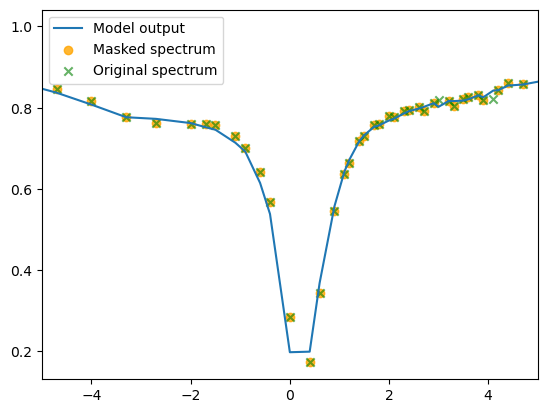

In [50]:
specNum = 7000
plt.plot(offsets, zspec_test_model_output[specNum,:], label = 'Model output')
plt.scatter(offsets, X_test_mask[specNum,:], label = 'Masked spectrum', alpha = 0.8, c = 'orange')
plt.scatter(offsets, X_test_ori[specNum,:], label = 'Original spectrum', c = 'green', marker = 'x', alpha = 0.6)
# plt.plot(offsets, np.abs(zspec_test_model_output[specNum,:] - X_test_ori[specNum,:]), label = 'Residual')
plt.legend()
plt.xlim([-5,5])

In [ ]:
print(np.sum([p.numel() for p in blochode.parameters()]))

### Test the FFN model

In [ ]:
testDataset_ffn = TensorDataset(torch.tensor(np.concatenate([params_test_select, B1_test_select, sat_test_select], axis = 1), dtype = torch.float32),
                                torch.tensor(zspec_test_select, dtype = torch.float32))

testLoader_ffn = DataLoader(testDataset_ffn)

In [ ]:
zspec_test_ffn_output = test_ffn(fullyconn_model, testLoader_ffn)

In [ ]:
specNum = 4000
plt.plot(offsets, zspec_test_ffn_output[specNum,:], label = 'Model output')
plt.scatter(offsets, zspec_test_select[specNum,:], label = 'Original spectrum', alpha = 0.6, c = 'orange')
plt.plot(offsets, zspec_test_ffn_output[specNum,:] - zspec_test_select[specNum,:], label = 'Residual')
plt.xlim([-5,5])
plt.legend()

### Calculate root mean squared error on test reuslts

In [ ]:
test_recon_error = np.sqrt(np.mean((zspec_test_model_output - zspec_test_select)**2, axis = 0))
test_recon_error = np.mean(test_recon_error)
print(test_recon_error)

In [ ]:
ffn_test_recon_error = np.mean((zspec_test_ffn_output - zspec_test_select)**2, axis = 0)
ffn_test_recon_error = np.mean(ffn_test_recon_error)
print(ffn_test_recon_error)